In [1]:
%load_ext autoreload
%autoreload 2
from numpy import sin, cos, pi, array
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import math


metadata = dict(title='Quad 2D', artist='Pete Florence',
        comment='Rotate time')
writer = animation.AVConvWriter(fps=20, metadata=metadata, bitrate=5000)


# constant velocity
v = 8

def derivs(state, t):

    dqdt = np.zeros_like(state)
    
    dqdt[0] = -v*sin(state[2])
    dqdt[1] = -v*cos(state[2]) 
    dqdt[2] = 0#sin(2*t)
    
    return dqdt

# create a time array from 0...30 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 4, dt)

# initial positions
# x and y are position of origin.  We move the origin, not the plane, so that the plane stays in the same spot in the plot.
# psi is yaw, and psidot is yawdot of plane
x = 0.0
y = 0.0
psi = 0.0

rad = pi/180.0

# initial state
state = np.array([x, y, psi*rad])

print "integrating..."
# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
print "done"

xworld = y[:,0]
yworld = y[:,1]
psiworld = y[:,2]

def rotateWorldIntoPlaneFrame(xworld,yworld,psiworld):
    Rtraj = np.sqrt(xworld**2 + yworld**2)
    thetatraj = np.arctan2(xworld, yworld)
    thetatraj = thetatraj - psiworld
    xtraj = Rtraj*np.sin(thetatraj)
    ytraj = Rtraj*np.cos(thetatraj)
    return xtraj, ytraj

xworld, yworld = rotateWorldIntoPlaneFrame(xworld,yworld,psiworld)
    
from ObstacleField import ObstacleField
from Obstacle import Obstacle

#Custom test field
# obsField = ObstacleField()
# obsField.addObstacle(Obstacle(3,4))
# obsField.addObstacle(Obstacle(-2,7))
# obsField.addObstacle(Obstacle(13,14))
# obsField.addObstacle(Obstacle(-12,17))
# obsField.addObstacle(Obstacle(23,24))
# obsField.addObstacle(Obstacle(-22,27))
# obsField.addObstacle(Obstacle(33,34))
# obsField.addObstacle(Obstacle(-12,37))
# obsField.addObstacle(Obstacle(13,44))
# obsField.addObstacle(Obstacle(-12,57))
# obsField.addObstacle(Obstacle(3,54))
# obsField.addObstacle(Obstacle(-2,53))

# # Random field
obsField = ObstacleField()
obsField.randomField(M=50)
for i in obsField.ObstaclesList:
    i.computeTraj(psiworld,xworld,yworld)

integrating...
done


precomputing laser data...
done


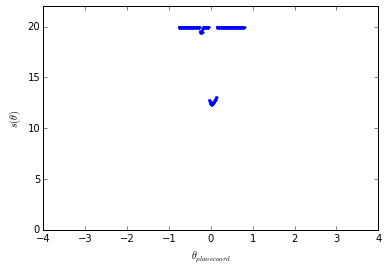

In [2]:
# Add laser
from libLaserDepths import computeLaserDepthsTraj
from LineCircleIntersect import intersect
laserLines = []
approxLines = []
D = 100 # Number of discrete data points from laser
laseAngles = np.linspace(math.pi/4,3*math.pi/4,D+1)[0:D]

#S_max
S_maxdist = 20
S_max_t = np.linspace(-math.pi,math.pi,100)
S_max_x = S_maxdist*np.cos(S_max_t)
S_max_y = S_maxdist*np.sin(S_max_t)

xlist = []
ylist = []

print "precomputing laser data..."
laserDepthsTraj, x_laser_endpointTraj, y_laser_endpointTraj = computeLaserDepthsTraj(xworld, yworld, laseAngles, S_maxdist, obsField)
print "done"


%matplotlib inline
from coordTransforms import transformStandardPolarTheta_to_PlaneTheta
laseAngles2 = laseAngles * 0
for i in range(len(laseAngles)):
    laseAngles2[i] = transformStandardPolarTheta_to_PlaneTheta(laseAngles[i])
    
    
plt.plot(laseAngles2,laserDepthsTraj[0,:],'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 22])
plt.show()

# import csv
# with open('laserdata.csv', 'wb') as csvfile:
#     laserwriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for i in range(len(laserDepths)):
#         laserwriter.writerow([laseAngles2[i], laserDepths[i]])


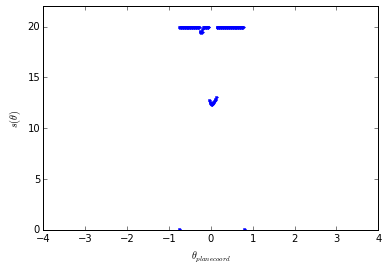

In [3]:
# Add limitation for edges
laserDepthsTraj[:,0] = 0.1
laserDepthsTraj[:,-1] = 0.1

plt.plot(laseAngles2,laserDepthsTraj[0,:],'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 22])
plt.show()

weighted numpy polynomial regression weights for N = 11
[  1.24521458e+01  -1.17333761e+01   1.55296168e+02   2.20234511e+02
  -7.22195209e+02  -1.42256110e+03  -4.67591704e+00   4.25924262e+03
   4.82179397e+03  -6.23507510e+03  -6.01828423e+03   3.68688512e+03]


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


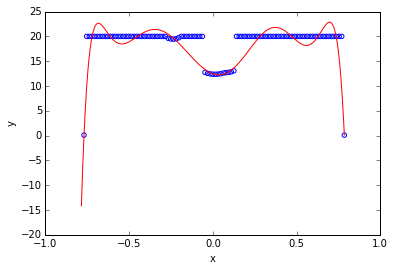

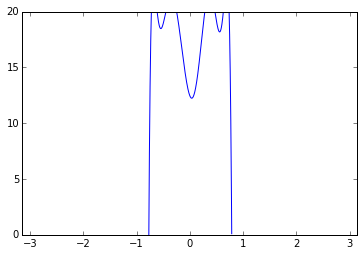

In [4]:
## Unconstrained

import scipy.optimize as opt
from linear_regression import LinearRegression

def plot(lr,w):
    # plot sin(2*phi*x) in green
    x = np.linspace(-math.pi/4,math.pi/4,1000)
    lr_temp = LinearRegression(x,x,lr.numFeatures-1)
    reg_prediction = np.dot(lr_temp.phi,w)
    plt.plot(x, reg_prediction, color='r')
    plt.scatter(lr.x, lr.y, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
N = 11
laserDepths = laserDepthsTraj[0,:]
lr = LinearRegression(laseAngles2,laserDepths,N)

print "weighted numpy polynomial regression weights for N = " + str(N)
weights = laserDepths * 1.0
#print weights
for index, value in enumerate(weights):
    weights[index] = (1/value)**4
#print weights
# an attempt to weight things in front more heavily 
# weights[len(weights)/4:3*len(weights)/4] = 10.0
w = np.polynomial.polynomial.polyfit(laseAngles2, laserDepths, N, w=weights)
print w
plot(lr,w)

def horner(x, weights):
    coefficients = weights[::-1]
    result = 0
    for i in coefficients:
        result = result * x + i
    return result

# def evalPoly(x, weights):
#     result = 0.0
#     for i in range(len(weights)):
#         result = result + weights[i] * (x**i)
#     return result

def plotHorner(w):
    x = np.linspace(-math.pi/4,math.pi/4,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = horner(x[index],w)
    plt.plot(x,y)
    plt.axis([-3.14, 3.14, 0, 20])
    plt.show()
    
plotHorner(w)

In [5]:
# Define matrices that then I will need


def setUpQP():
    
    #A = feature matrix
    
    lr = LinearRegression(laseAngles2,laserDepths,N)
    A_pete = lr.phi
    
    #W = weighting matrix
    weights = laserDepths * 1.0
    for index, value in enumerate(weights):
        weights[index] = (1/value)**4
    W_pete = np.diag(weights)
    
    #b = vector of sensor measurements
    b_pete = laserDepths
    
    return np.matrix(A_pete), np.matrix(W_pete), np.matrix(b_pete)
    
A_pete, W_pete, b_pete = setUpQP()

print np.shape(A_pete)
print np.shape(A_pete.T)
print np.shape(A_pete * A_pete.T)
print np.shape(A_pete.T * A_pete)

(100, 12)
(12, 100)
(100, 100)
(12, 12)


     pcost       dcost       gap    pres   dres
 0: -1.0014e+02  2.5821e+02  5e+03  2e-01  5e-01
 1: -1.0013e+02 -1.9491e+02  1e+02  5e-03  1e-02
 2: -1.0012e+02 -1.0113e+02  1e+00  5e-05  1e-04
 3: -1.0013e+02 -1.0016e+02  3e-02  5e-07  1e-06
 4: -1.0014e+02 -1.0014e+02  3e-03  2e-15  4e-12
 5: -1.0014e+02 -1.0014e+02  8e-04  2e-15  2e-12
 6: -1.0014e+02 -1.0014e+02  2e-04  1e-15  1e-12
 7: -1.0014e+02 -1.0014e+02  4e-05  1e-15  9e-13
Optimal solution found.
[[   12.01388699]
 [   -9.5511771 ]
 [  134.56565865]
 [  153.32327137]
 [ -668.24672591]
 [ -877.81303181]
 [  514.48100145]
 [ 2359.94610474]
 [ 2613.93481894]
 [-3182.27263558]
 [-3867.4756017 ]
 [ 1823.65465982]]


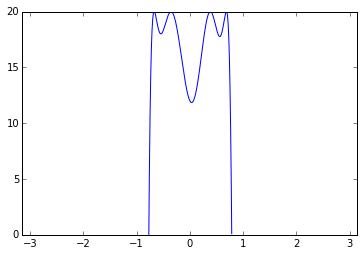

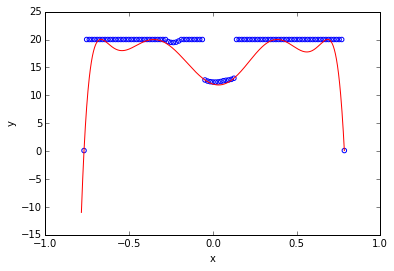

In [6]:
import cvxopt

# P = A^T W A
P = cvxopt.matrix(A_pete.T * W_pete * A_pete)

# q^T = -b^T A
# q = -A^T b
q = cvxopt.matrix(- A_pete.T * W_pete *b_pete.T)

# G = A
G = cvxopt.matrix(A_pete)

# h = b_pete
h = cvxopt.matrix(b_pete.T)

A_zeros = np.copy(A_pete)
A_zeros[::] = 0

b_zeros = np.copy(b_pete)
b_zeros[:] = 0

A = cvxopt.matrix(A_zeros)
b = cvxopt.matrix(b_zeros.T)

# find the solution 
solution = cvxopt.solvers.qp(P, q, G, h)

alpha = np.array(solution['x'])

print alpha

def plotHorner(w):
    x = np.linspace(-math.pi/4,math.pi/4,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = horner(x[index],w)
    plt.plot(x,y)
    plt.axis([-3.14, 3.14, 0, 20])
    plt.show()
    
plotHorner(alpha)


def plotConstrained(w):
    x = np.linspace(-math.pi/4,math.pi/4,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = horner(x[index],w)
    plt.plot(x,y, color='r')
    plt.scatter(laseAngles2, laserDepths, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
plotConstrained(alpha)    


In [7]:
# simulate pixel dynamics

def pixelDerivs(pixelState, t):

    dqdt = np.zeros_like(pixelState)
    
    u = sin(2*t)   
    dqdt[0]  = -v  # world coming towards plane
    dqdt[-1] = 0  # world turning with plane (mean)
    
    return dqdt

# initial state
pixelState = alpha[:,0]
pixelState = np.hstack((pixelState, 0))

print "integrating..."
# integrate your ODE using scipy.integrate.
pixelY = integrate.odeint(pixelDerivs, pixelState, t)
print "done"

print np.shape(pixelY)

# for i in range(len(t)):
#     print i
#     plotHorner(pixelY[i][:-1])

integrating...
done
(80, 13)


0


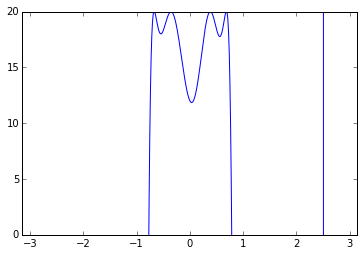

1


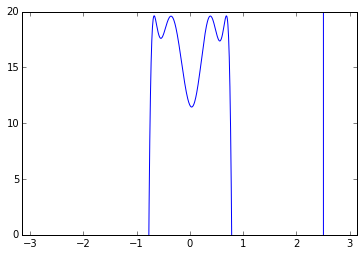

2


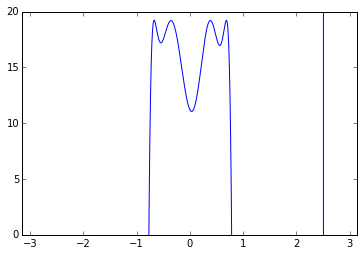

3


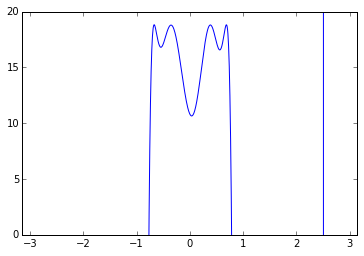

4


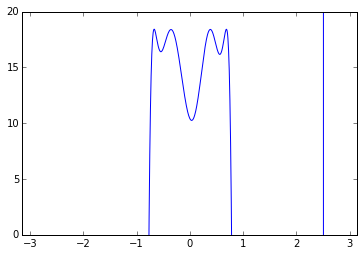

5


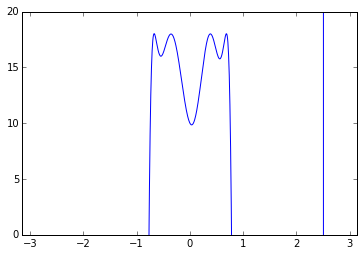

6


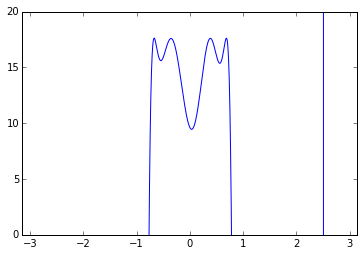

7


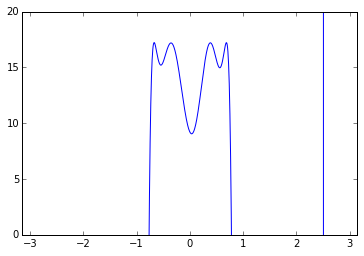

8


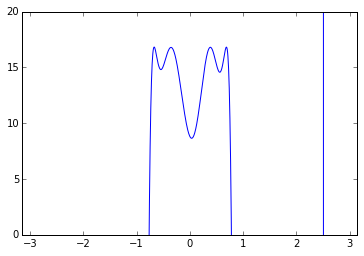

9


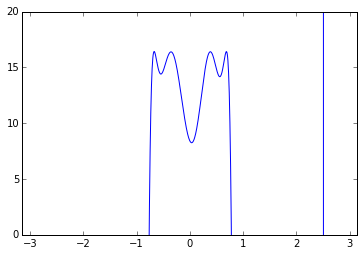

10


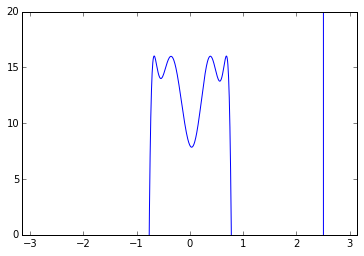

11


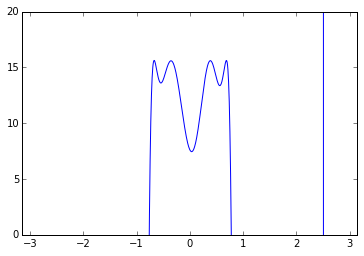

12


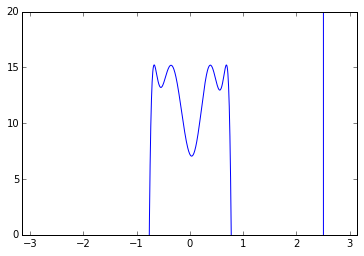

13


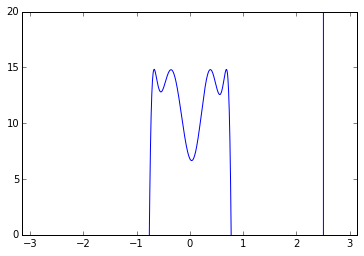

14


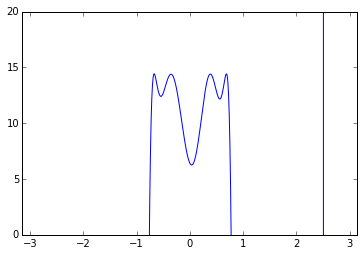

15


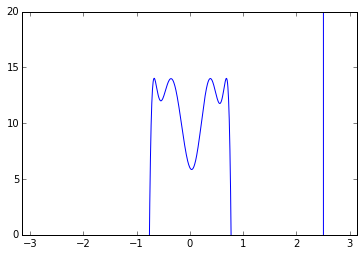

16


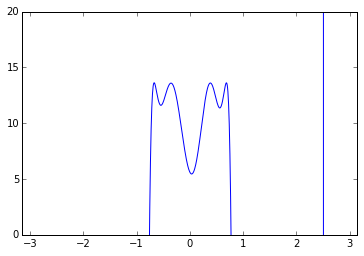

17


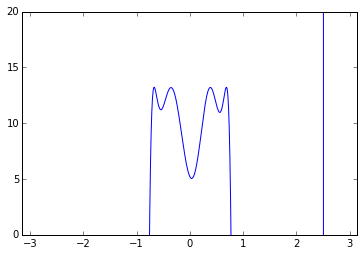

18


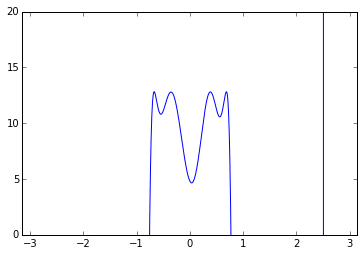

19


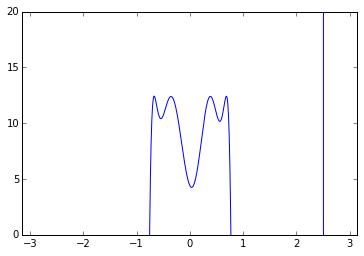

20


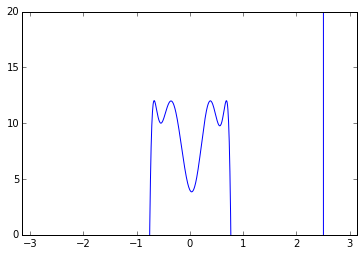

21


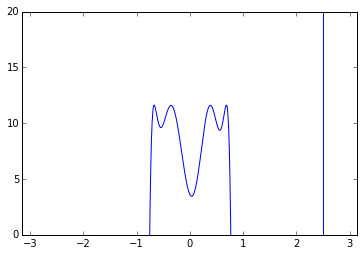

22


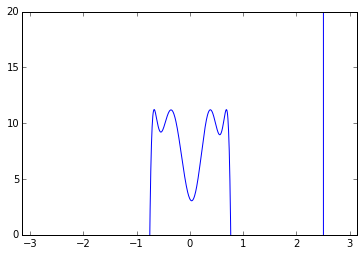

23


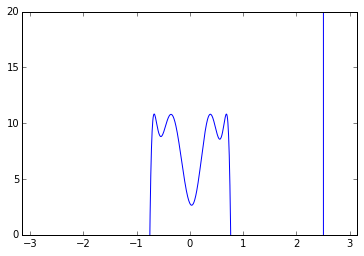

24


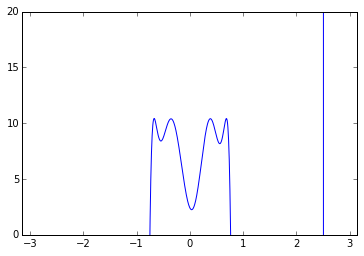

25


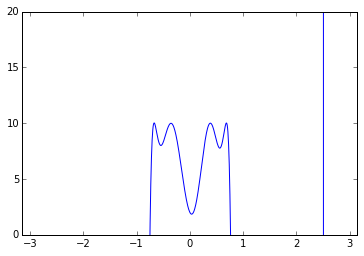

26


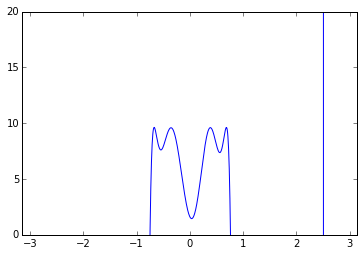

27


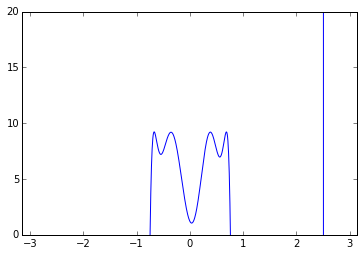

28


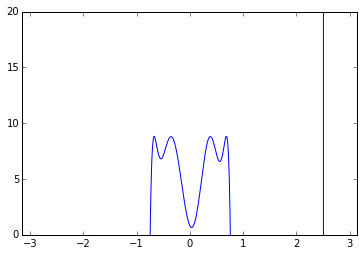

29


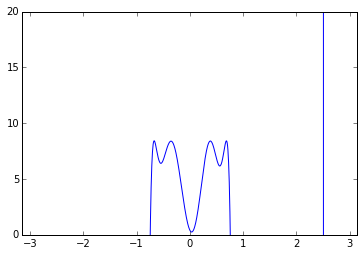

30


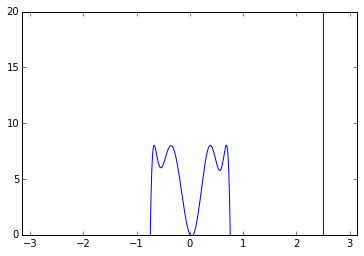

31


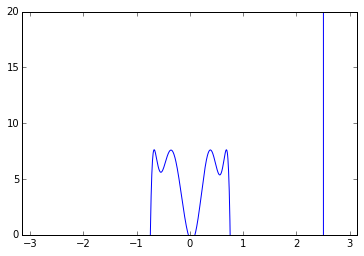

32


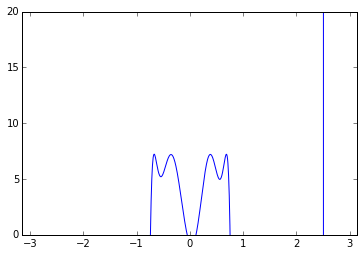

33


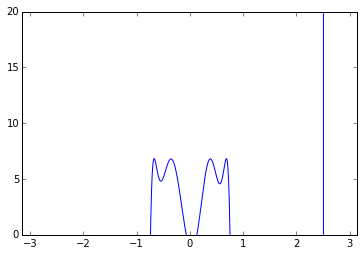

34


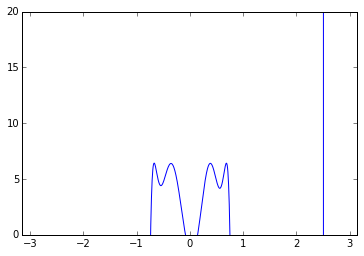

35


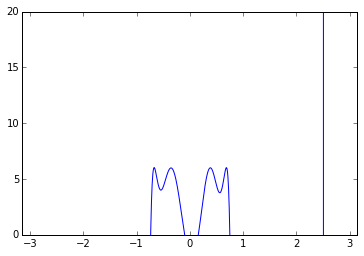

36


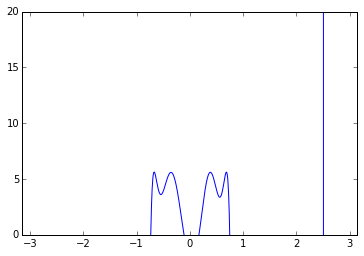

37


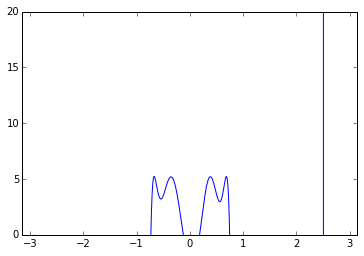

38


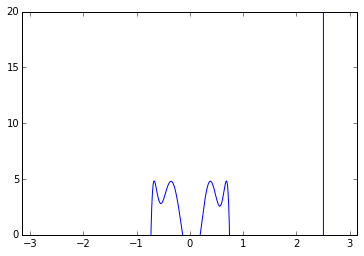

39


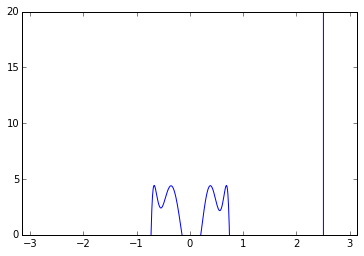

40


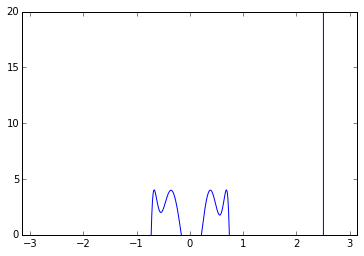

41


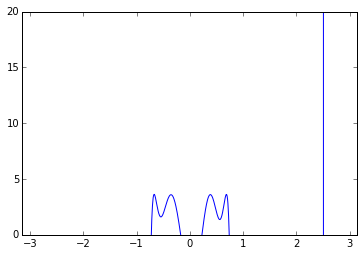

42


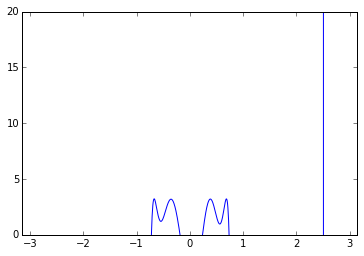

43


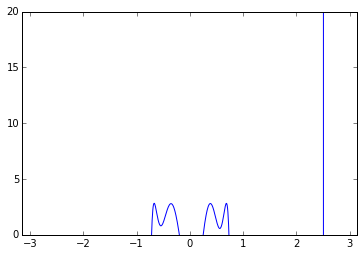

44


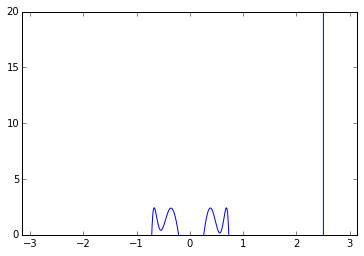

45


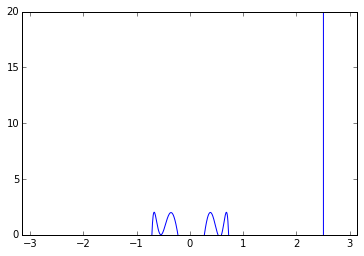

46


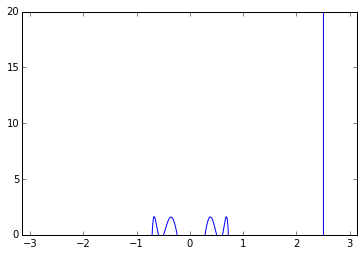

47


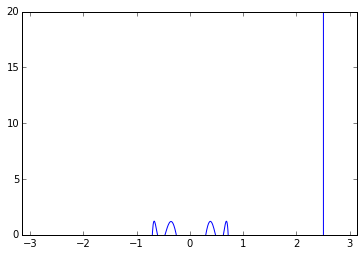

48


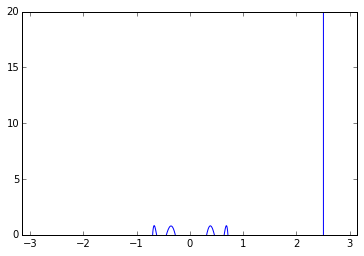

49


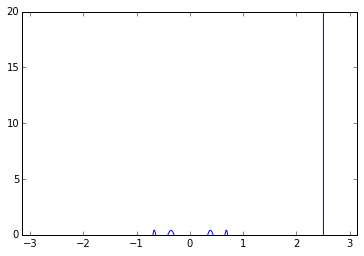

50


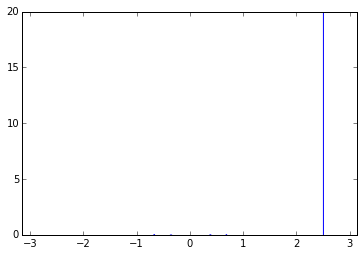

51


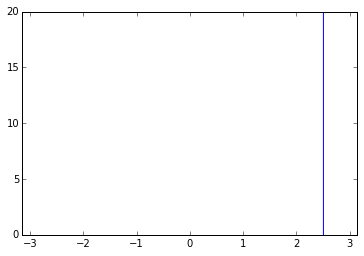

52


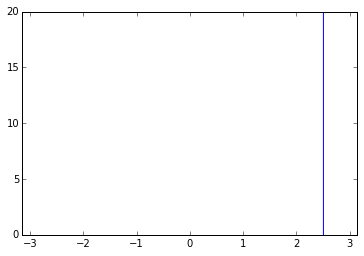

53


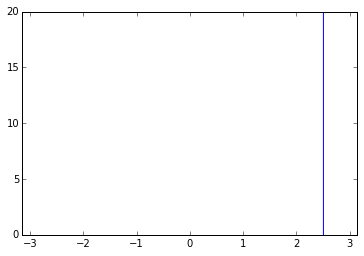

54


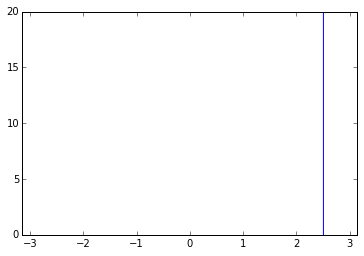

55


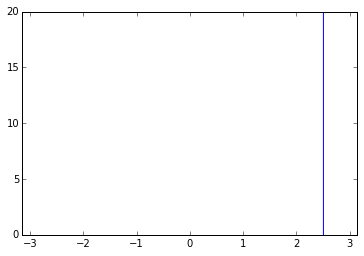

56


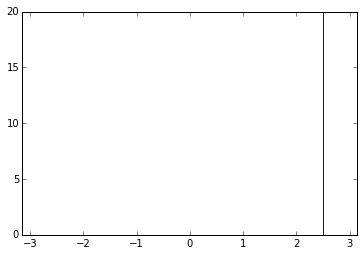

57


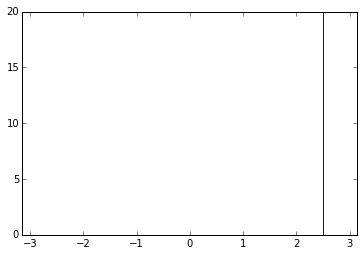

58


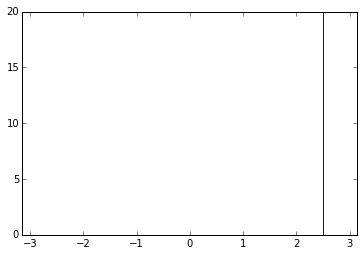

59


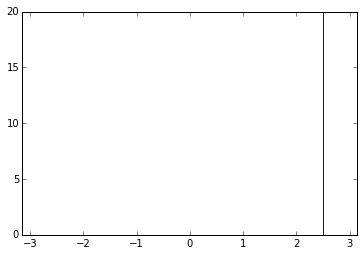

60


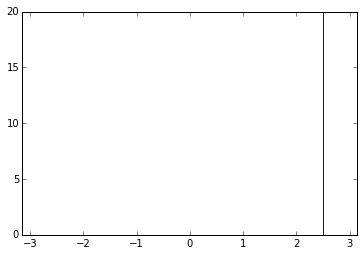

61


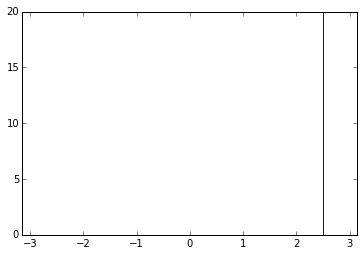

62


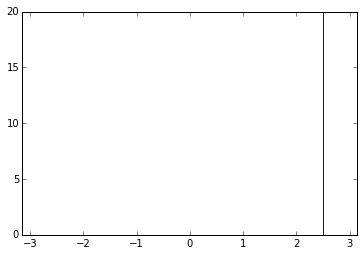

63


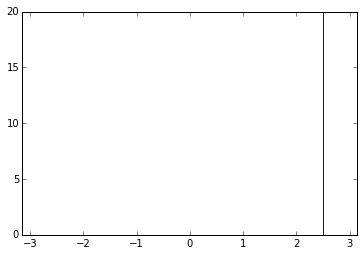

64


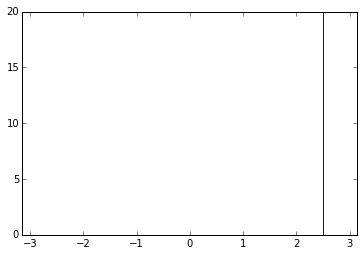

65


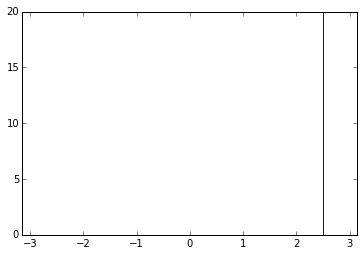

66


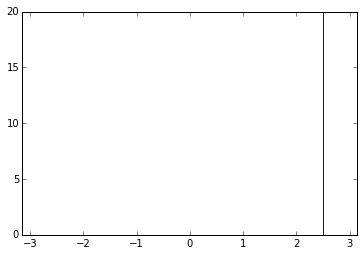

67


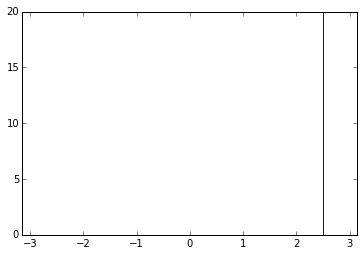

68


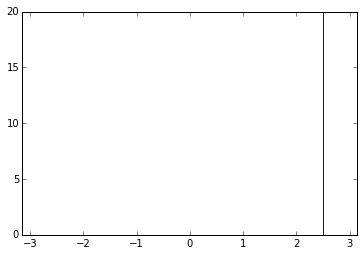

69


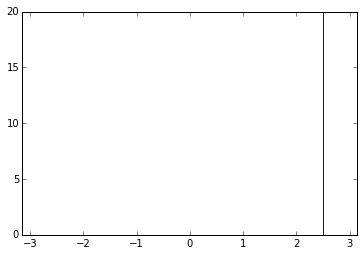

70


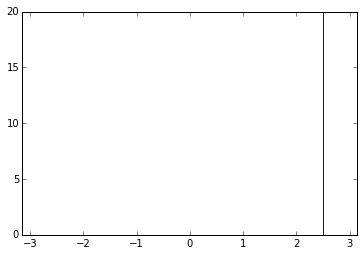

71


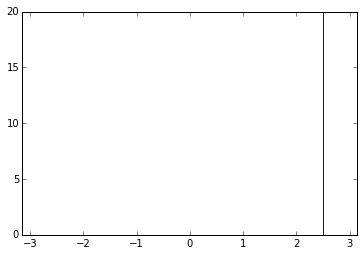

72


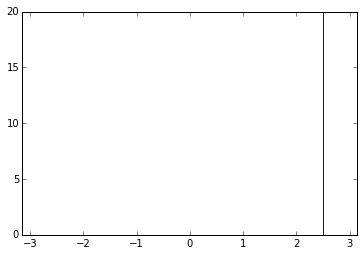

73


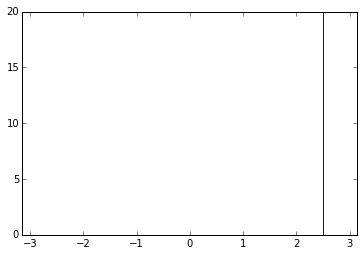

74


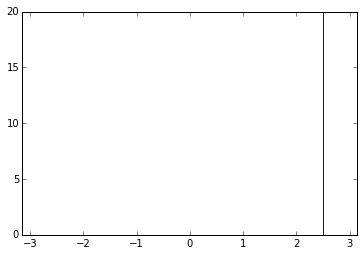

75


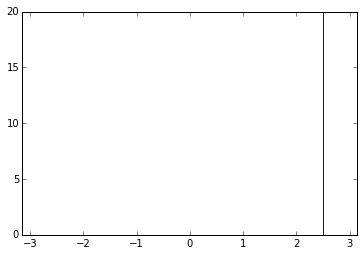

76


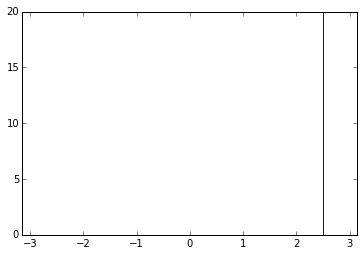

77


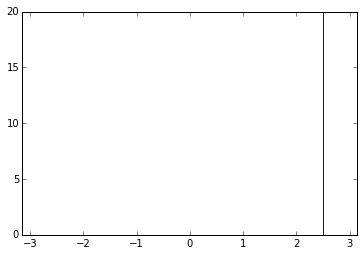

78


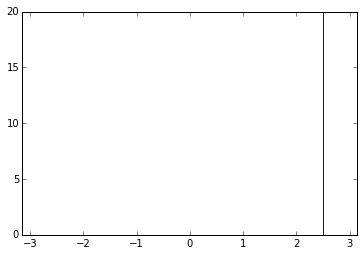

79


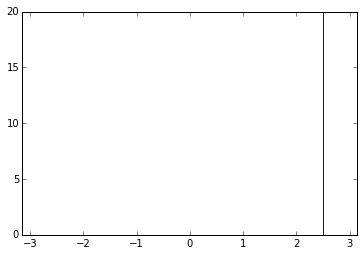

In [8]:
def hornerMovingMean(x, weights, mean):
    coefficients = weights[::-1]
    result = 0
    for i in coefficients:
        result = result * (x-mean) + i
    return result

def plotHornerMovingMean(weights, mean):
    x = np.linspace(-math.pi,math.pi,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = hornerMovingMean(x[index], weights, mean)
    plt.plot(x,y)
    plt.axis([-3.14, 3.14, 0, 20])
    plt.show()

for i in range(len(t)):
    print i
    plotHornerMovingMean(pixelY[i][:-1],pixelY[i][-1])

In [9]:
import os
os.system("rm bot.mp4")
%matplotlib qt
plt.rcParams['figure.figsize'] = 20, 15
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-50, 50), ylim=(-20, 50))
ax.grid()

im = plt.imread('quaddrawing.png')
newax = fig.add_axes([0.497, 0.31, 0.03, 0.1], anchor='SW')
newax.imshow(im)
newax.axis('off')
ax.set_aspect('equal', 'datalim')
     
S_max, = ax.plot([], [], '--' , lw=1, color='red')   
obstacles, = ax.plot([], [], 'o', markersize=20, lw=2, color='gray')
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

for index in range(D):
    lobj = ax.plot([],[],'-',lw=0.5,color='red')[0]
    laserLines.append(lobj)
    approxobj = ax.plot([],[],'-',lw=0.5,color='green')[0]
    approxLines.append(approxobj)

def init():
    S_max.set_data([], [])
    obstacles.set_data([], [])
    time_text.set_text('')
    
    for line in laserLines:
        line.set_data([],[])
        
    for approxLine in approxLines:
        approxLine.set_data([],[])
    
    return obstacles, time_text, laserLines, approxLines

def animate(i):
    
    # Draw the maximum sensor horizon
    S_max.set_data(S_max_x,S_max_y)
    
    
    # Draw the obstacles as just a bunch of points
    
    all_obs_x = []
    all_obs_y = []
    
    for obs in obsField.ObstaclesList:
        all_obs_x.append(obs.xtraj[i]) #+ obs.plotX) put back in this to plot little points around the circle
        all_obs_y.append(obs.ytraj[i]) #+ obs.plotY)
    
    #all_obs_x = [x_obj1[i], x_obj2[i]]
    #all_obs_y = [y_obj1[i], y_obj2[i]]
    obstacles.set_data(all_obs_x, all_obs_y)
    
    # Draw in the time
    time_text.set_text(time_template%(i*dt))
    
    xlist = []
    ylist = []
    approx_xlist = []
    approx_ylist = []
    
    # Draw the laser intersecting obstacles
    for lasenum, lasevalue in enumerate(laseAngles):

        x_laser_endpoint = x_laser_endpointTraj[i,lasenum]
        y_laser_endpoint = y_laser_endpointTraj[i,lasenum]
        

#         xlist.append([[0,x_laser_endpoint]])
#         ylist.append([[0,y_laser_endpoint]])
        # currently turned off drawing
        xlist.append([[0,0]])
        ylist.append([[0,0]])
        
        # Draw the approximation
        lasevalue2 = transformStandardPolarTheta_to_PlaneTheta(lasevalue)
        Ymean = pixelY[i][-1]
        Yweights = pixelY[i][:-1]
        
        approx_distance = hornerMovingMean(lasevalue2,Yweights,Ymean)
        # check if negative, just don't plot if it is
        if (approx_distance < 0):
            #print "found one at ", lasevalue2
            approx_distance = 0
        
        
        x_approx_endpoint = approx_distance*math.cos(lasevalue)
        y_approx_endpoint = approx_distance*math.sin(lasevalue)
        
        if (lasevalue2 - Ymean < math.pi/4) and (Ymean - lasevalue2 < math.pi/4):
            approx_xlist.append([[0,x_approx_endpoint]])
            approx_ylist.append([[0,y_approx_endpoint]])
        else:
            approx_xlist.append([[0,0]])
            approx_ylist.append([[0,0]])

    for lnum,line in enumerate(laserLines):
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 
        
    for lnum,approxline in enumerate(approxLines):
        approxline.set_data(approx_xlist[lnum], approx_ylist[lnum]) # set data for each line separately. 

    return obstacles, time_text, laserLines, approxLines

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
    interval=20, blit=False, init_func=init)
ani.save('bot.mp4', fps=20, bitrate=5000, codec="h264", writer=writer)
plt.show()

In [10]:
# import os
# os.system("rm bot_h264.mp4")
# os.system("avconv -i bot.mp4 -c:v h264 -c:a copy bot_h264.mp4")

In [11]:
# import os
# import io
# import base64
# from IPython.display import HTML

# video = io.open('/Users/pflomacpro/GeometricPDEs/_Plane/bot_h264.mp4', 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))